In [326]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Get OpenStreetMap Data

For this, we use the OSMPythonTools package as recommended by the OSM wiki. It allows us to access the Overpass API (a read-only API, perfect for what we are set to do), the OSM API, and the Nominatim access point. More info here: https://wiki.openstreetmap.org/wiki/OSMPythonTools

#### Which object does the way with the id 5887599 represent?

In [2]:
from OSMPythonTools.api import Api
api = Api()
way = api.query('way/5887599')

#### How many trees are in the OSM data of Vienna? And how many trees have there been in 2013?

In [3]:
# Find the id for the area Vienna
from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()
areaId = nominatim.query('Vienna, Austria').areaId()
print('Vienna Id:', areaId)

Vienna Id: 3600109166


In [4]:
# query the Overpass API for the numbe of trees in Vienna using the id we just retrieved.
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
overpass = Overpass()
query = overpassQueryBuilder(area=areaId, elementType='node', selector='"natural"="tree"', out='count')
result = overpass.query(query)
print('there are', result.countElements(), 'trees in Vienna')

there are 143275 trees in Vienna


In [5]:
# How many were there in 2013 ?
result = overpass.query(query, date='2013-01-01T00:00:00Z', timeout=60)
print('there were', result.countElements(), 'trees in Vienna in 2013')

there were 127690 trees in Vienna in 2013


#### How did the number of trees changed in Vienna, Paris and Berlin changed since 2013? 

In [11]:
from collections import OrderedDict
from OSMPythonTools.data import Data, dictRangeYears, ALL
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

# The question has two "dimensions": the dimension of time, and the dimension of different cities: 
dimensions = OrderedDict([
    ('year', dictRangeYears(2013, 2017.5, 1)),
    ('city', OrderedDict({
        'berlin': 'Berlin, Germany',
        'paris': 'Paris, France',
        'vienna': 'Vienna, Austria',
    })),
])

In [12]:
# fetch the number of trees for the three cities, each year since 2013. It can take a while
overpass = Overpass()
def fetch(year, city):
    areaId = nominatim.query(city).areaId()
    query = overpassQueryBuilder(area=areaId, elementType='node', selector='"natural"="tree"', out='count')
    return overpass.query(query, date=year, timeout=60).countElements()
data = Data(fetch, dimensions)

[nominatim] downloading data: search
[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600062422)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[nominatim] downloading data: search
[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600007444)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600062422)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600007444)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600109166)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2015-01-01T00:00:00Z"][out:json];area(3600062422

In [153]:
# Plot it in a .jpg picture
data.plot(city=ALL, filename='example.png')

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'data' is not defined

In [15]:
# Or get it as a .csv
print(data.select(city=ALL).getCSV())

year,berlin,paris,vienna
2013.0,10180,1936,127690
2014.0,17971,26905,128906
2015.0,28277,90602,130279
2016.0,86769,103175,132294
2017.0,108432,103249,134617



# Can we get the streets from Edinburgh ?

Following the indications in :
    
https://automating-gis-processes.github.io/site/notebooks/L6/retrieve_osm_data.html

In [6]:
import osmnx as ox
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

# Specify the name that is used to seach for the data
# place_name = "Bruntsfield, Edinburgh, Scotland"
place_name = "Fountainbridge, Edinburgh, Scotland"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name, )

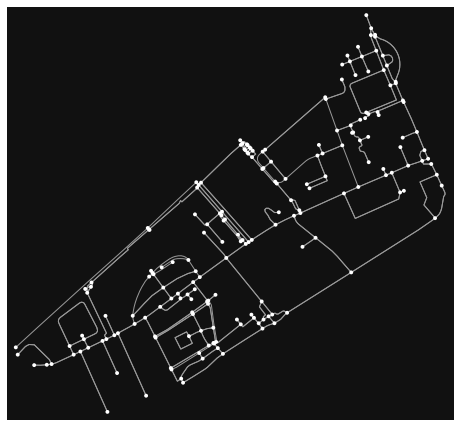

In [7]:
# Plot the streets
fig, ax = ox.plot_graph(graph)

(-3.2229898250000004, -3.2073054749999996, 55.938265915, 55.946192185)

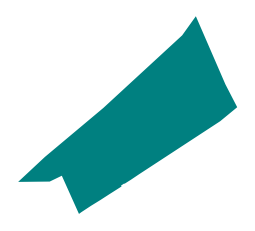

In [8]:
fig,ax = plt.subplots()
fig.patch.set_alpha(0)
area = ox.geocode_to_gdf(place_name)
area.plot(ax=ax, color='teal')
plt.axis('off')

# Get some specific info from OSM

(The outdated queries in the course have been updated as per changelog here: https://github.com/gboeing/osmnx/issues/526)

#### Bicycle lanes

As advised here: https://help.openstreetmap.org/questions/64879/get-all-bicycle-infrastructure-for-a-city

<blockquote>
To get all cycle infrastructure you will need to retrieve at least:
    <ul>
<li>all roads that have additional tags indicating cycle infrastructure (cycleway=lane and cycleway=track)</li>
<li>all highway=cycleway</li>
<li>all highway=footway and highway=path that allow bicycle use or are intended for such (bicycle=yes, bicycle=designated, bicycle=official)</li>
    </ul>
</blockquote>

#### Roads and highways

In [9]:
tags={'highway':True}
highways = ox.geometries_from_place(place_name, tags)
highways.highway.value_counts()

footway            62
service            43
residential        27
steps              24
tertiary           14
path               11
bus_stop            9
crossing            8
unclassified        6
give_way            6
pedestrian          6
traffic_signals     5
cycleway            3
Name: highway, dtype: int64

In [11]:
highways.loc['way', ['highway','bicycle','cycleway:both','geometry','lanes','nodes','oneway']].fillna('').head(5)

,highway,bicycle,cycleway:both,geometry,lanes,nodes,oneway
osmid,,,,,,,
4189740,service,,,"LINESTRING (-3.21771 55.94051, -3.21775 55.940...",1,"[251878909, 2414435295, 1190835263, 2414435301...",yes
4196544,footway,designated,,"LINESTRING (-3.21857 55.94025, -3.21862 55.940...",,"[614632, 8238695440, 8238695439, 684717569]",
4196545,footway,designated,,"LINESTRING (-3.21921 55.94111, -3.21953 55.94148)",,"[24556887, 69079746]",
4196547,residential,,,"LINESTRING (-3.21833 55.93876, -3.21853 55.939...",,"[24557144, 22453445, 3342281271, 8307342238, 6...",
4196549,residential,,,"LINESTRING (-3.21823 55.93862, -3.21833 55.93876)",,"[24668796, 24557144]",


In [12]:
highways.loc['way', ['highway', 'bicycle','cycleway:both','lanes','oneway']].fillna('').drop_duplicates().sort_values(by='highway')

,highway,bicycle,cycleway:both,lanes,oneway
osmid,,,,,
248993062,cycleway,designated,,,
4196544,footway,designated,,,
54294275,footway,no,,,
4247171,footway,,,,
54168192,footway,yes,,,
48553636,path,,,,
23189262,path,designated,,,
911530112,pedestrian,,,,
55493443,pedestrian,yes,,,


#### How to extract the bike lanes from this?

In [14]:
import numpy as np

bicycle_filters = []

for column in ['cycleway', 'cycleway:left', 'cycleway:right', 'cycleway:both']:
    if column not in highways.columns: continue
    bicycle_filters.append(highways[column]=='lane')

bicycle_filters.append(highways['highway']=='cycleway')
bicycle_filters.append(highways['bicycle']=='designated')
bicycle_filters=np.array(bicycle_filters)
bicycle_filters=np.any(bicycle_filters, axis=0)

highways[bicycle_filters].loc['way', ['highway','bicycle','cycleway:both','geometry','lanes','nodes','oneway']].fillna('')

,highway,bicycle,cycleway:both,geometry,lanes,nodes,oneway
osmid,,,,,,,
4196544,footway,designated,,"LINESTRING (-3.21857 55.94025, -3.21862 55.940...",,"[614632, 8238695440, 8238695439, 684717569]",
4196545,footway,designated,,"LINESTRING (-3.21921 55.94111, -3.21953 55.94148)",,"[24556887, 69079746]",
4526717,pedestrian,designated,,"LINESTRING (-3.21113 55.94139, -3.20909 55.942...",,"[22453491, 2395519385, 2272868841, 2293636277]",
23189262,path,designated,,"LINESTRING (-3.21113 55.94139, -3.21308 55.940...",,"[22453491, 28099761, 3701320658, 1833351765, 3...",
41474216,path,designated,,"LINESTRING (-3.21445 55.94357, -3.21438 55.943...",,"[2407874176, 693731169, 2327956292, 2327956296...",
54294277,footway,designated,,"LINESTRING (-3.21915 55.94104, -3.21903 55.941...",,"[684717569, 684717575, 684717579, 24556887]",
55180211,footway,designated,,"LINESTRING (-3.21414 55.94335, -3.21416 55.94334)",,"[507395791, 693731170]",
214767920,footway,designated,,"LINESTRING (-3.21576 55.94288, -3.21569 55.942...",,"[3707704789, 5029334437, 2336835527, 693731166]",
222362355,path,designated,,"LINESTRING (-3.21624 55.93951, -3.21635 55.939...",,"[28099770, 3695991118, 3382232722, 2696990907,...",


#### Restaurants

In [15]:
tags = {'amenity':True, 'landuse':['restaurant']}
restaurants = ox.geometries_from_place(place_name, tags)
restaurants.amenity.value_counts()

bench                 40
bicycle_parking       24
waste_basket          14
cafe                   8
fast_food              8
parking                8
restaurant             5
atm                    5
parking_entrance       3
telephone              3
bicycle_rental         3
community_centre       2
car_sharing            2
recycling              2
pub                    2
motorcycle_parking     2
vending_machine        1
arts_centre            1
post_box               1
library                1
casino                 1
cinema                 1
bar                    1
clock                  1
school                 1
Name: amenity, dtype: int64

#### Buildings

In [16]:
tags = {'building':True}
buildings = ox.geometries_from_place(place_name, tags=tags)
buildings.amenity.value_counts()

library    1
cafe       1
Name: amenity, dtype: int64

#### Bicycle rentals

In [17]:
tags = {'amenity':'bicycle_rental'}
bike_stations = ox.geometries_from_place(place_name, tags)

#### Parks and green spaces

In [18]:
tags = {'leisure':True}
leisure = ox.geometries_from_place(place_name, tags)
leisure.leisure.value_counts()

garden              58
picnic_table         4
escape_game          1
playground           1
fitness_centre       1
miniature_golf       1
sports_centre        1
fitness_station      1
pitch                1
amusement_arcade     1
bowling_alley        1
trampoline_park      1
park                 1
Name: leisure, dtype: int64

In [19]:
nodes, edges = ox.graph_to_gdfs(graph)

In [20]:
from pyproj import CRS

# Set projection
projection = CRS.from_epsg(3067)

# Re-project layers
area = area.to_crs(projection)
edges = edges.to_crs(projection)
buildings = buildings.to_crs(projection)
restaurants = restaurants.to_crs(projection)
leisure = leisure.to_crs(projection)
highways = highways.to_crs(projection)
bike_stations = bike_stations.to_crs(projection)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


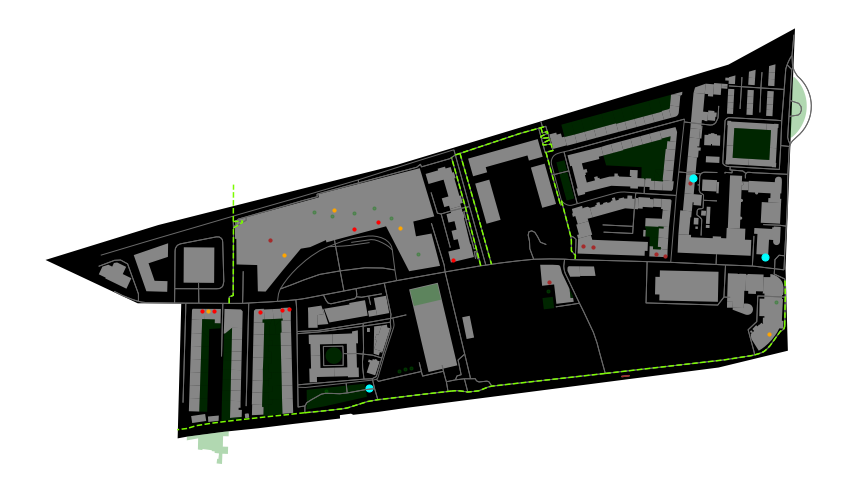

In [21]:
fig, ax = plt.subplots(figsize=(12,8))

fig.patch.set_alpha(0)

# AREAS
# Plot the footprint
area.plot(ax=ax, facecolor='black')
# Plot buildings
buildings.plot(ax=ax, facecolor='silver', alpha=0.7)
# Plot churches
restaurants[restaurants.amenity=='place_of_worship'].plot(ax=ax, color='purple', alpha=.7, markersize=10)
# Plot parks
leisure.plot(ax=ax, color='green', alpha=0.3, markersize=10)

# LINES
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')
# Plot cycle ways
highways[bicycle_filters].plot(ax=ax, color='lawngreen', alpha=1, ls='--')

# POINTS
# Plot restaurants
restaurants[restaurants.amenity=='restaurant'].plot(ax=ax, color='orange', alpha=1, markersize=10)
# Plot cafes
restaurants[restaurants.amenity=='cafe'].plot(ax=ax, color='brown', alpha=1, markersize=10)
# Plot fast food
restaurants[restaurants.amenity=='fast_food'].plot(ax=ax, color='red', alpha=1, markersize=10)
# Plot JustEat stations in cyan; 
bike_stations.plot(ax=ax, color='cyan', alpha=1, markersize=50)

plt.axis('off')

plt.tight_layout()

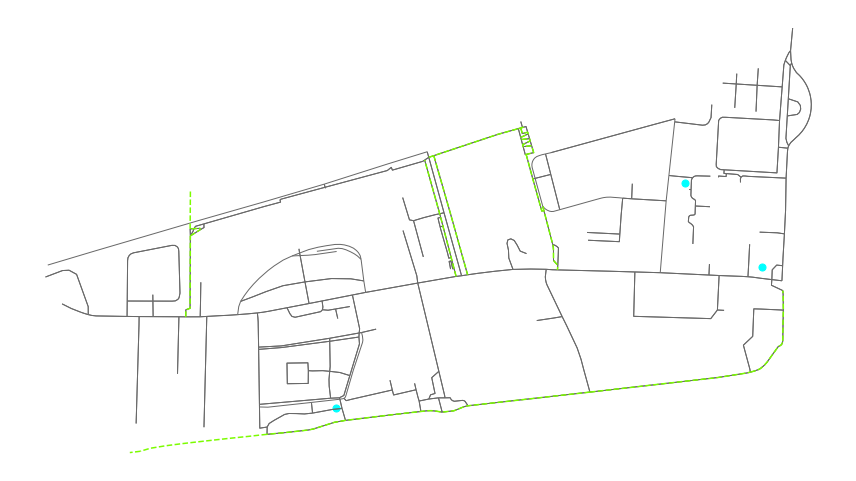

In [22]:
fig, ax = plt.subplots(figsize=(12,8))

fig.patch.set_alpha(0)

# LINES
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')
# Plot cycle ways
highways[bicycle_filters].plot(ax=ax, color='lawngreen', alpha=1, ls='--')

# POINTS
# Plot JustEat stations in cyan; 
bike_stations.plot(ax=ax, color='cyan', alpha=1, markersize=50)

plt.axis('off')

plt.tight_layout()

# Path from a bike rental to the next

Let's see if we can plot a trip from one station to the next.

In [23]:
import networkx as nx
import pandas as pd

# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we will need some sort of metric system; therefore we need to project our graph: As the data is in WGS84 format, we should first reproject our data into a metric system. We can re-project the graph from latitudes and longitudes to an appropriate UTM zone:

In [29]:
graph_proj = ox.project_graph(graph)

# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
# Project our bike stations dataset in the same coordinates system
bike_stations_proj = bike_stations.to_crs(nodes_proj.crs)

# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
centroid = convex_hull.centroid

# Calculate the area
area = convex_hull.area

print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


### Calculate network stats

In [171]:
# Calculate network statistics
stats = ox.basic_stats(graph_proj, circuity_dist='euclidean')

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, cc=True)

# Add extened statistics to the basic statistics
for key, value in extended_stats.items():
    stats[key] = value

# Convert the dictionary to a Pandas series for a nicer output
pd.Series(stats)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\osmnx\stats.py:405: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


n                                                                                    195
m                                                                                    480
k_avg                                                                           4.923077
edge_length_total                                                              17219.672
edge_length_avg                                                                35.874317
streets_per_node_avg                                                            2.717949
streets_per_node_counts                               {0: 0, 1: 39, 2: 1, 3: 131, 4: 24}
streets_per_node_proportions           {0: 0.0, 1: 0.2, 2: 0.005128205128205128, 3: 0...
intersection_count                                                                   156
street_length_total                                                             9277.283
street_segment_count                                                                 252
street_length_avg    

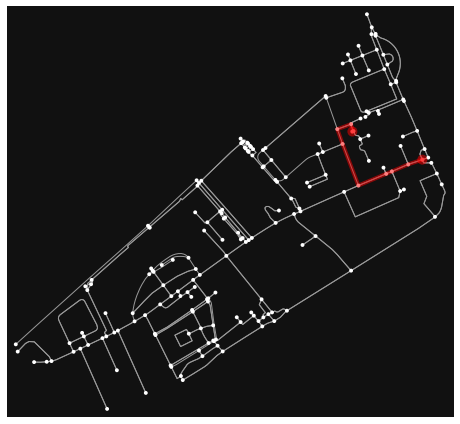

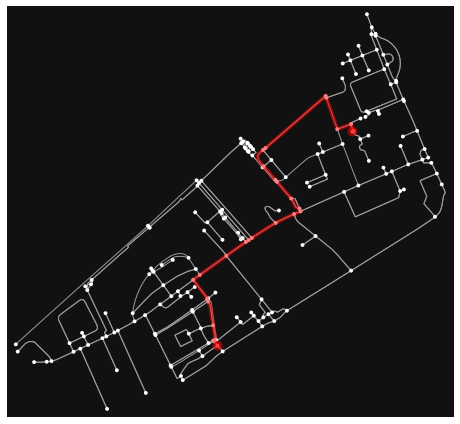

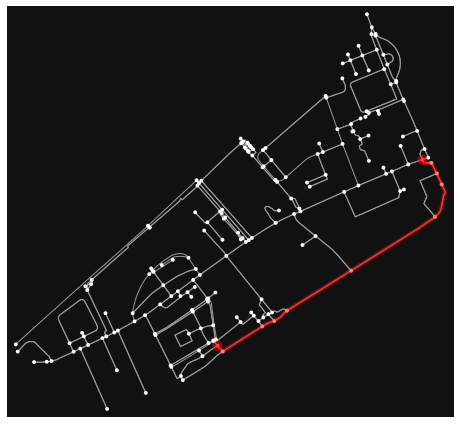

In [30]:
for i in range(3):
    
    orig_node = ox.distance.nearest_nodes(graph_proj, *bike_stations_proj.iloc[i%3].geometry.xy)
    target_node = ox.distance.nearest_nodes(graph_proj, *bike_stations_proj.iloc[(i+1)%3].geometry.xy)
    
    route = nx.shortest_path(G=graph_proj, 
                             source=orig_node[0],
                             target=target_node[0],
                             weight='length')

    # Plot the shortest path
    fig, ax = ox.plot_graph_route(graph_proj, route)